# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

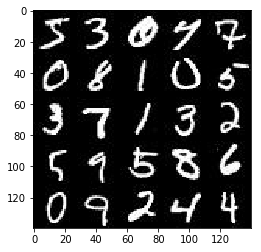

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

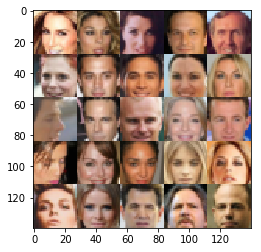

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


/Users/Tote/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_input_images = tf.placeholder(dtype=tf.float32, shape=[None, image_width, image_height, image_channels], name='real_input')
    z_data = tf.placeholder(dtype=tf.float32, shape=[None, z_dim], name='z')
    learning_rate = tf.placeholder(dtype=tf.float32, shape=[], name='learning_rate')

    return real_input_images, z_data, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False, alpha= 0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    #28x28x3
    with tf.variable_scope("discriminator", reuse=reuse):
        x1 = tf.layers.conv2d(inputs=images, filters=64, kernel_size=(5, 5), strides=2, padding="valid")
        relu1 = tf.maximum(x1 * alpha, x1)
        #12x12x64
        
        x2 = tf.layers.conv2d(relu1, 128, (5, 5), 2, padding="same")
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(bn2 * alpha, bn2)
        #6x6x128
        
        x3 = tf.layers.conv2d(relu2, 256, (3, 3), 1, padding="same")
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(bn3 * alpha, bn3)
        #6x6x256
        
        #flatten image
        flat = tf.reshape(relu3, [-1, 6*6*256])
        
        logits = tf.layers.dense(inputs=flat, units=1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2, reuse=False):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope("generator", reuse=not is_train):
        x1 = tf.layers.dense(inputs=z, units=7*7*512)
        x1 = tf.reshape(x1, [-1, 7, 7, 512])
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(x1 * alpha, x1)
        # 7x7x512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding="same")
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(x2 * alpha, x2)
        #14x14x256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding="same")
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(x3 * alpha, x3)
        #28x28x128
        
        x4 = tf.layers.conv2d_transpose(x3, 64, 3, strides=1, padding="same")
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(x4*alpha, x4)
        #28x28x64
        
        logits = tf.layers.conv2d(x4, out_channel_dim, 5, strides=1, padding="same")
        #28x28xout_channel_dim
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Retrieve weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    #optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    _, image_width, image_height, num_channels = data_shape
    real_input, z, learning_rate_t = model_inputs(image_width, image_height, num_channels, z_dim)
    d_loss_t, g_loss_t = model_loss(real_input, z, num_channels)
    d_train_opt, g_train_opt = model_opt(d_loss_t, g_loss_t, learning_rate, beta1)
    
    g_losses = []
    d_losses = []
    steps = 0
    print_step = 20
    show_step = 100
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                feed = {real_input: batch_images, z: batch_z, learning_rate_t: learning_rate}
                
                _, _ = sess.run([g_loss_t, g_train_opt], feed_dict=feed)
                g_loss, _ = sess.run([g_loss_t, g_train_opt], feed_dict=feed)
                d_loss, _ = sess.run([d_loss_t, d_train_opt], feed_dict=feed)
                d_losses.append(d_loss)
                g_losses.append(g_loss)
                
                if steps % print_step == 0:
                    
                    print("Step {}, Epoch {}/{}...".format(steps, epoch_i+1, epoch_count),
                          "Discriminator loss: {:.4f}...".format(d_loss),
                          "Generator loss: {:.4f}".format(g_loss))
                    
                #if steps % show_step == 0:
                    show_generator_output(sess, 32, z, num_channels, data_image_mode)
                steps += 1

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Step 0, Epoch 1/2... Discriminator loss: 6.0069... Generator loss: 0.0230


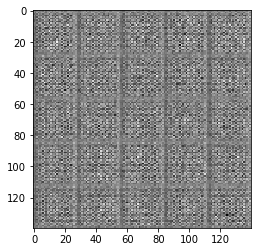

Step 20, Epoch 1/2... Discriminator loss: 3.3653... Generator loss: 0.7205


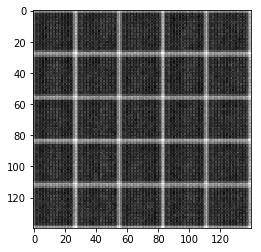

Step 40, Epoch 1/2... Discriminator loss: 2.4968... Generator loss: 0.5930


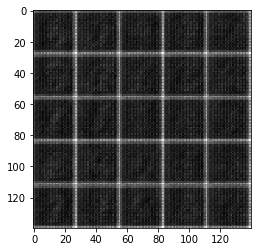

Step 60, Epoch 1/2... Discriminator loss: 1.8873... Generator loss: 0.5821


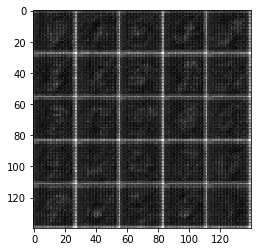

Step 80, Epoch 1/2... Discriminator loss: 2.0329... Generator loss: 0.6730


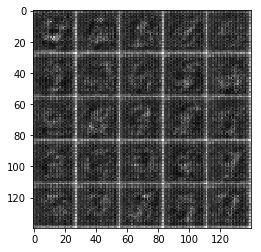

Step 100, Epoch 1/2... Discriminator loss: 1.6620... Generator loss: 0.6733


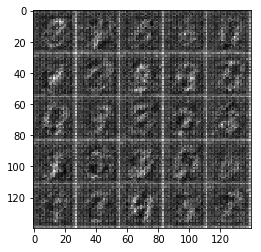

Step 120, Epoch 1/2... Discriminator loss: 1.4486... Generator loss: 0.9176


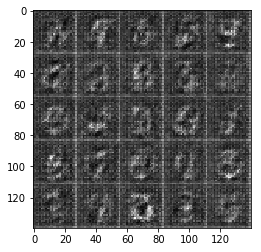

Step 140, Epoch 1/2... Discriminator loss: 1.2734... Generator loss: 1.0901


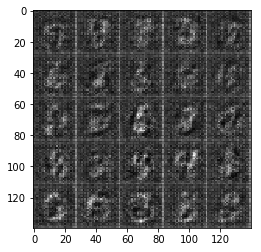

Step 160, Epoch 1/2... Discriminator loss: 1.4504... Generator loss: 0.8499


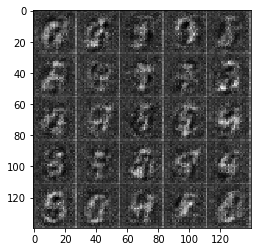

Step 180, Epoch 1/2... Discriminator loss: 1.2467... Generator loss: 0.9674


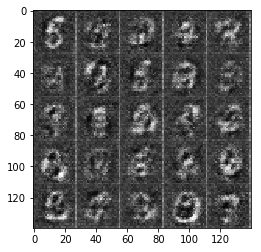

Step 200, Epoch 1/2... Discriminator loss: 1.1520... Generator loss: 1.1168


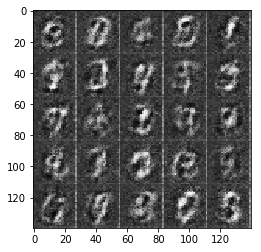

Step 220, Epoch 1/2... Discriminator loss: 1.3023... Generator loss: 1.2752


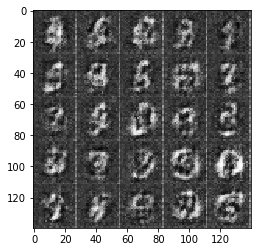

Step 240, Epoch 1/2... Discriminator loss: 1.2161... Generator loss: 1.1748


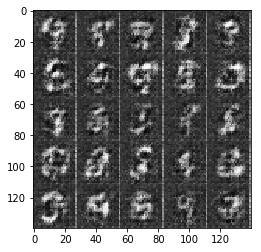

Step 260, Epoch 1/2... Discriminator loss: 0.8745... Generator loss: 1.5121


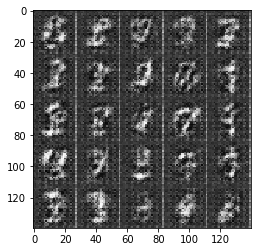

Step 280, Epoch 1/2... Discriminator loss: 1.0432... Generator loss: 0.9428


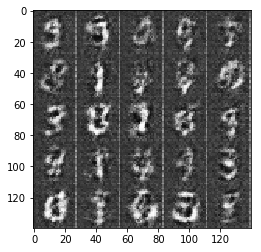

Step 300, Epoch 1/2... Discriminator loss: 0.9508... Generator loss: 1.2641


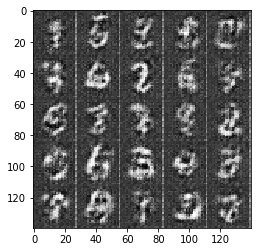

Step 320, Epoch 1/2... Discriminator loss: 0.8528... Generator loss: 1.6606


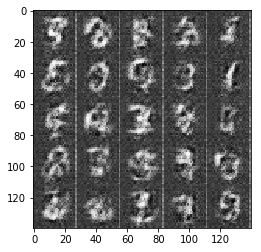

Step 340, Epoch 1/2... Discriminator loss: 1.0771... Generator loss: 1.0724


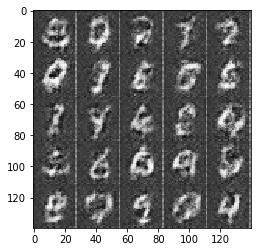

Step 360, Epoch 1/2... Discriminator loss: 1.0507... Generator loss: 1.2229


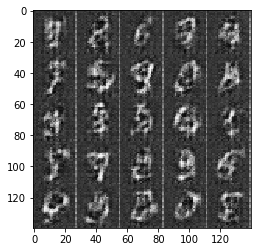

Step 380, Epoch 1/2... Discriminator loss: 0.7127... Generator loss: 1.7220


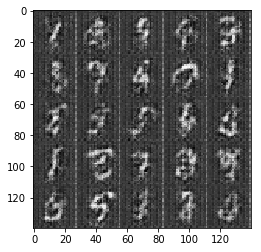

Step 400, Epoch 1/2... Discriminator loss: 1.1383... Generator loss: 1.5795


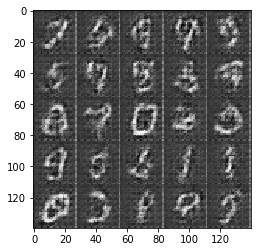

Step 420, Epoch 1/2... Discriminator loss: 1.0597... Generator loss: 2.1413


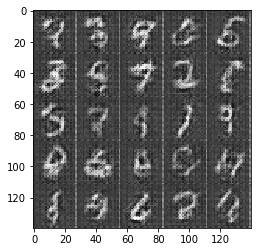

Step 440, Epoch 1/2... Discriminator loss: 1.1759... Generator loss: 1.1588


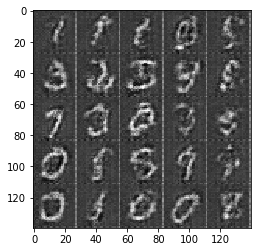

Step 460, Epoch 1/2... Discriminator loss: 1.1286... Generator loss: 1.1680


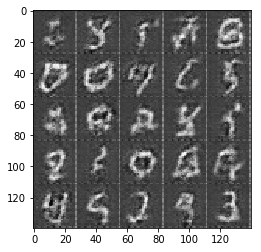

Step 480, Epoch 1/2... Discriminator loss: 0.9763... Generator loss: 1.7712


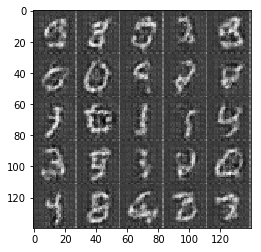

Step 500, Epoch 1/2... Discriminator loss: 1.1959... Generator loss: 0.9052


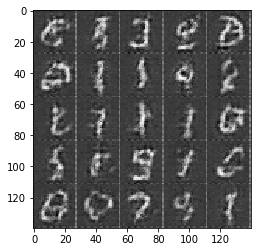

Step 520, Epoch 1/2... Discriminator loss: 1.0867... Generator loss: 1.7034


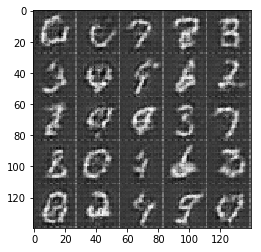

Step 540, Epoch 1/2... Discriminator loss: 1.2717... Generator loss: 1.6196


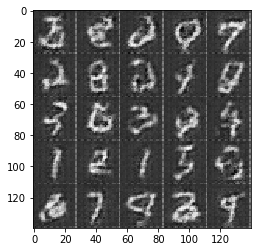

Step 560, Epoch 1/2... Discriminator loss: 1.1442... Generator loss: 0.7191


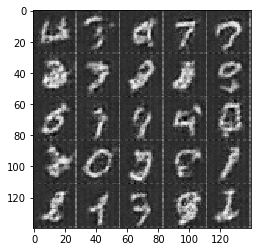

Step 580, Epoch 1/2... Discriminator loss: 1.2162... Generator loss: 0.9362


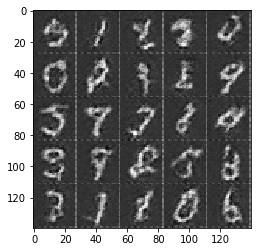

Step 600, Epoch 1/2... Discriminator loss: 1.0874... Generator loss: 1.8878


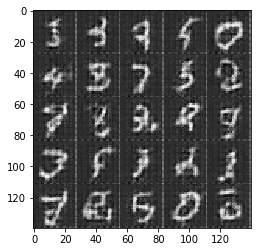

Step 620, Epoch 1/2... Discriminator loss: 1.0339... Generator loss: 1.4075


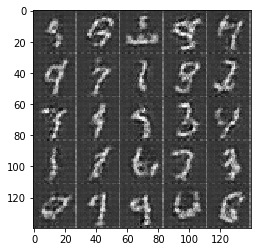

Step 640, Epoch 1/2... Discriminator loss: 0.9253... Generator loss: 1.1264


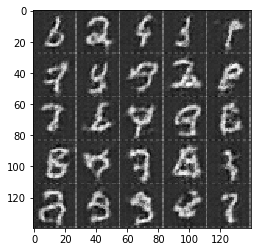

Step 660, Epoch 1/2... Discriminator loss: 1.1320... Generator loss: 1.5423


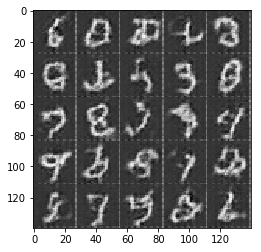

Step 680, Epoch 1/2... Discriminator loss: 0.9436... Generator loss: 1.3015


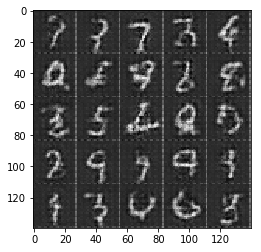

Step 700, Epoch 1/2... Discriminator loss: 1.0026... Generator loss: 1.5237


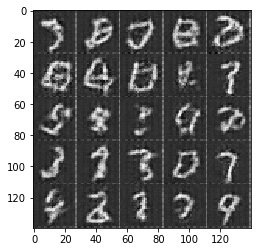

Step 720, Epoch 1/2... Discriminator loss: 0.9890... Generator loss: 1.3225


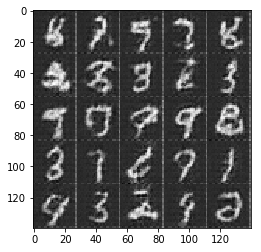

Step 740, Epoch 1/2... Discriminator loss: 0.8818... Generator loss: 1.6555


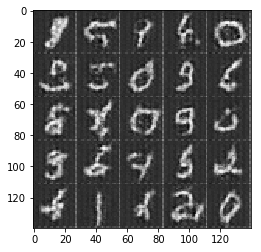

Step 760, Epoch 1/2... Discriminator loss: 0.6869... Generator loss: 1.7098


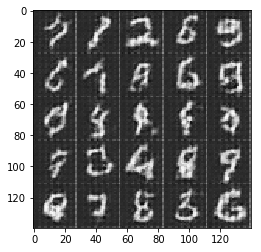

Step 780, Epoch 1/2... Discriminator loss: 1.2601... Generator loss: 0.6643


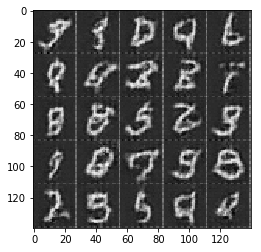

Step 800, Epoch 1/2... Discriminator loss: 0.9019... Generator loss: 1.7749


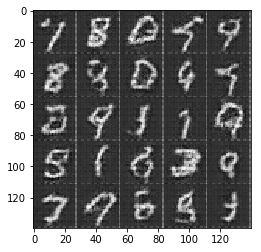

Step 820, Epoch 1/2... Discriminator loss: 1.1481... Generator loss: 0.7694


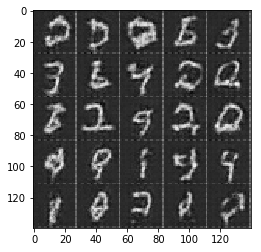

Step 840, Epoch 1/2... Discriminator loss: 0.9447... Generator loss: 1.8325


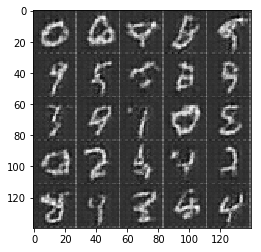

Step 860, Epoch 1/2... Discriminator loss: 1.3523... Generator loss: 0.5741


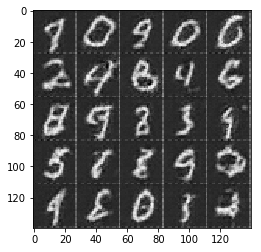

Step 880, Epoch 1/2... Discriminator loss: 0.8537... Generator loss: 1.6934


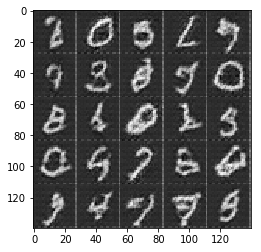

Step 900, Epoch 1/2... Discriminator loss: 1.0252... Generator loss: 1.0325


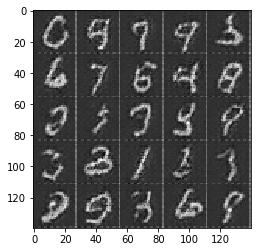

Step 920, Epoch 1/2... Discriminator loss: 1.0506... Generator loss: 0.7754


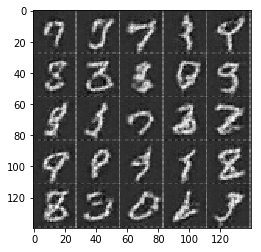

Step 940, Epoch 2/2... Discriminator loss: 0.9917... Generator loss: 1.3985


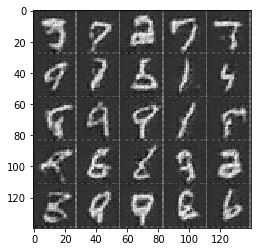

Step 960, Epoch 2/2... Discriminator loss: 0.7257... Generator loss: 1.8647


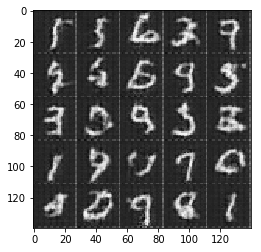

Step 980, Epoch 2/2... Discriminator loss: 1.1305... Generator loss: 1.9244


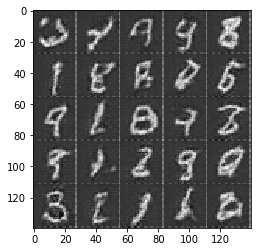

KeyboardInterrupt: 

In [12]:
batch_size = 64
z_dim = 120
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Step 0, Epoch 1/1... Discriminator loss: 9.0891... Generator loss: 0.0016


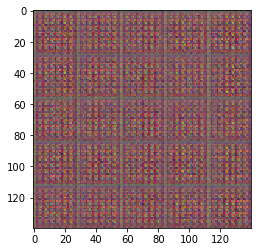

Step 20, Epoch 1/1... Discriminator loss: 3.2409... Generator loss: 1.3850


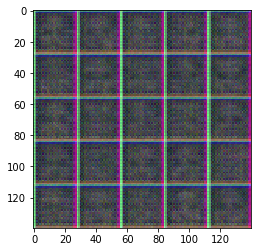

Step 40, Epoch 1/1... Discriminator loss: 2.3251... Generator loss: 0.8733


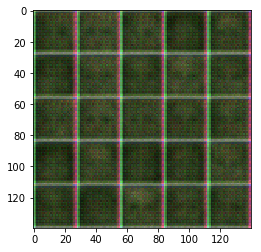

Step 60, Epoch 1/1... Discriminator loss: 1.5794... Generator loss: 1.2508


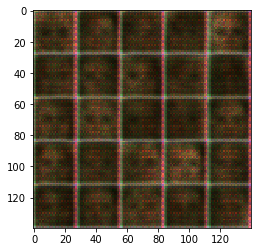

Step 80, Epoch 1/1... Discriminator loss: 1.8125... Generator loss: 1.5196


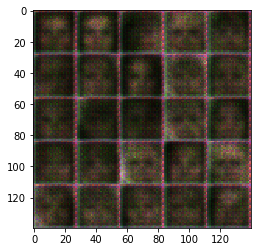

Step 100, Epoch 1/1... Discriminator loss: 0.8189... Generator loss: 1.9314


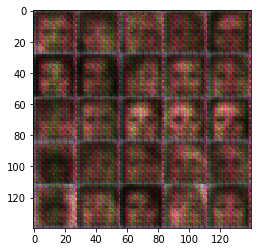

Step 120, Epoch 1/1... Discriminator loss: 0.5456... Generator loss: 3.4047


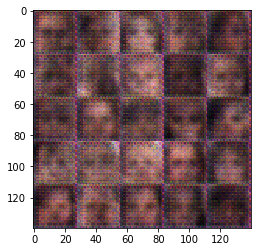

Step 140, Epoch 1/1... Discriminator loss: 2.0249... Generator loss: 1.3135


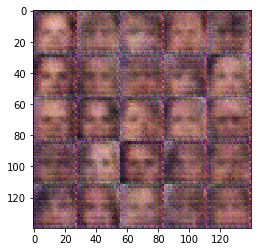

Step 160, Epoch 1/1... Discriminator loss: 2.3068... Generator loss: 0.6760


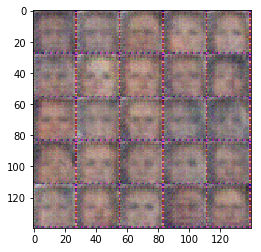

Step 180, Epoch 1/1... Discriminator loss: 1.8546... Generator loss: 0.6716


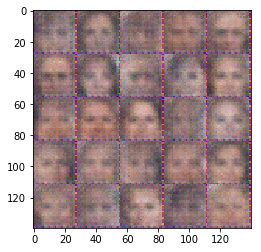

Step 200, Epoch 1/1... Discriminator loss: 1.5719... Generator loss: 0.6969


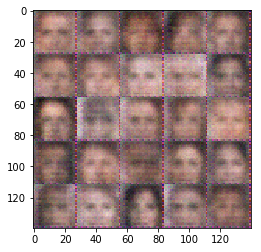

Step 220, Epoch 1/1... Discriminator loss: 1.5709... Generator loss: 0.7100


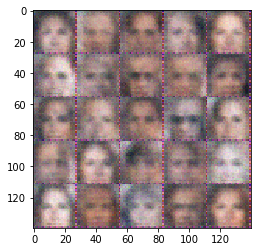

Step 240, Epoch 1/1... Discriminator loss: 1.6085... Generator loss: 0.6929


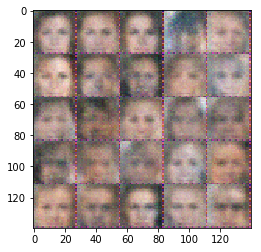

Step 260, Epoch 1/1... Discriminator loss: 1.6059... Generator loss: 0.6207


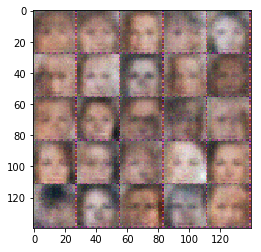

Step 280, Epoch 1/1... Discriminator loss: 1.4897... Generator loss: 0.7000


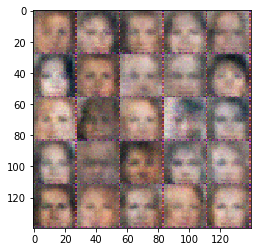

Step 300, Epoch 1/1... Discriminator loss: 1.5378... Generator loss: 0.7152


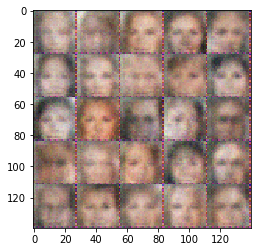

Step 320, Epoch 1/1... Discriminator loss: 1.5358... Generator loss: 0.6986


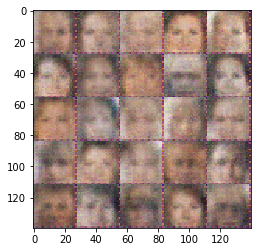

Step 340, Epoch 1/1... Discriminator loss: 1.5944... Generator loss: 0.6806


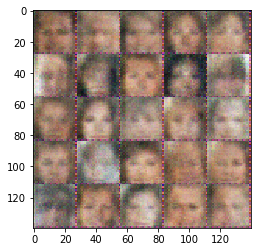

Step 360, Epoch 1/1... Discriminator loss: 1.5176... Generator loss: 0.6430


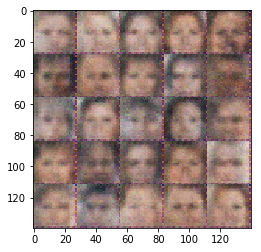

Step 380, Epoch 1/1... Discriminator loss: 1.4714... Generator loss: 0.7310


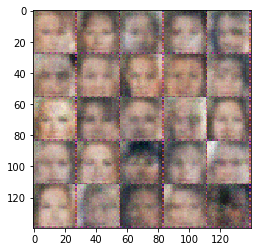

Step 400, Epoch 1/1... Discriminator loss: 1.5045... Generator loss: 0.6652


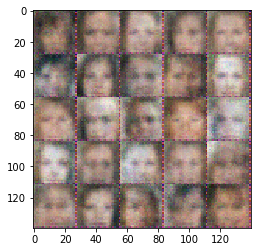

Step 420, Epoch 1/1... Discriminator loss: 1.4902... Generator loss: 0.7032


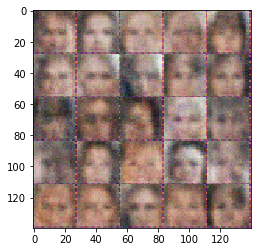

Step 440, Epoch 1/1... Discriminator loss: 1.4875... Generator loss: 0.6988


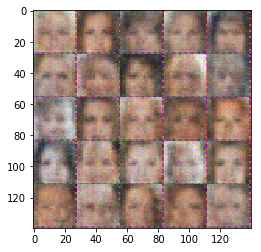

In [ ]:
batch_size = 64
z_dim = 120
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.